In [1]:
import scanpy as sc
import multimil as mtm
import anndata as ad
import numpy as np
# import scib
import pandas as pd
import matplotlib.pyplot as plt
import scvi
from sklearn.metrics import classification_report, accuracy_score
import scipy.stats as st

sc.set_figure_params(dpi=100, frameon=False, facecolor=None, transparent=True)

[rank: 0] Global seed set to 0
/home/icb/zihe.zheng/miniconda3/envs/multimil2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

## preprocess for prediction

In [ ]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_hvg_umap_scvi.h5ad')
adata

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color = ['state'], ncols = 1)

In [ ]:
sc.pl.umap(adata, color = ['subset'], ncols = 1)

In [ ]:
# remove samples that does not have individual ID and one patietn that only has one cell??
# adata.obs.individualID.value_counts()
adata = adata[~adata.obs.individualID.isin(['NA', 'R5026720'])]
plt.hist(adata.obs.individualID.value_counts())

In [ ]:
# add column for AD based on cerad scrore
adata.obs['AD'] = adata.obs['ceradsc'].isin([1, 2])

In [ ]:
# add column for APOE label
adata.obs['apoe_label'] = adata.obs['apoe_genotype'].astype(str).apply(lambda x: x.count('4'))
adata.obs['apoe_label'].value_counts()

In [ ]:
adata.obs = adata.obs.reset_index(drop = True)

In [ ]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready.h5ad')

## visualize integration

In [4]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 1625707 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels', 'AD', 'apoe_label'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'pca', 'state_colors', 'subset_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

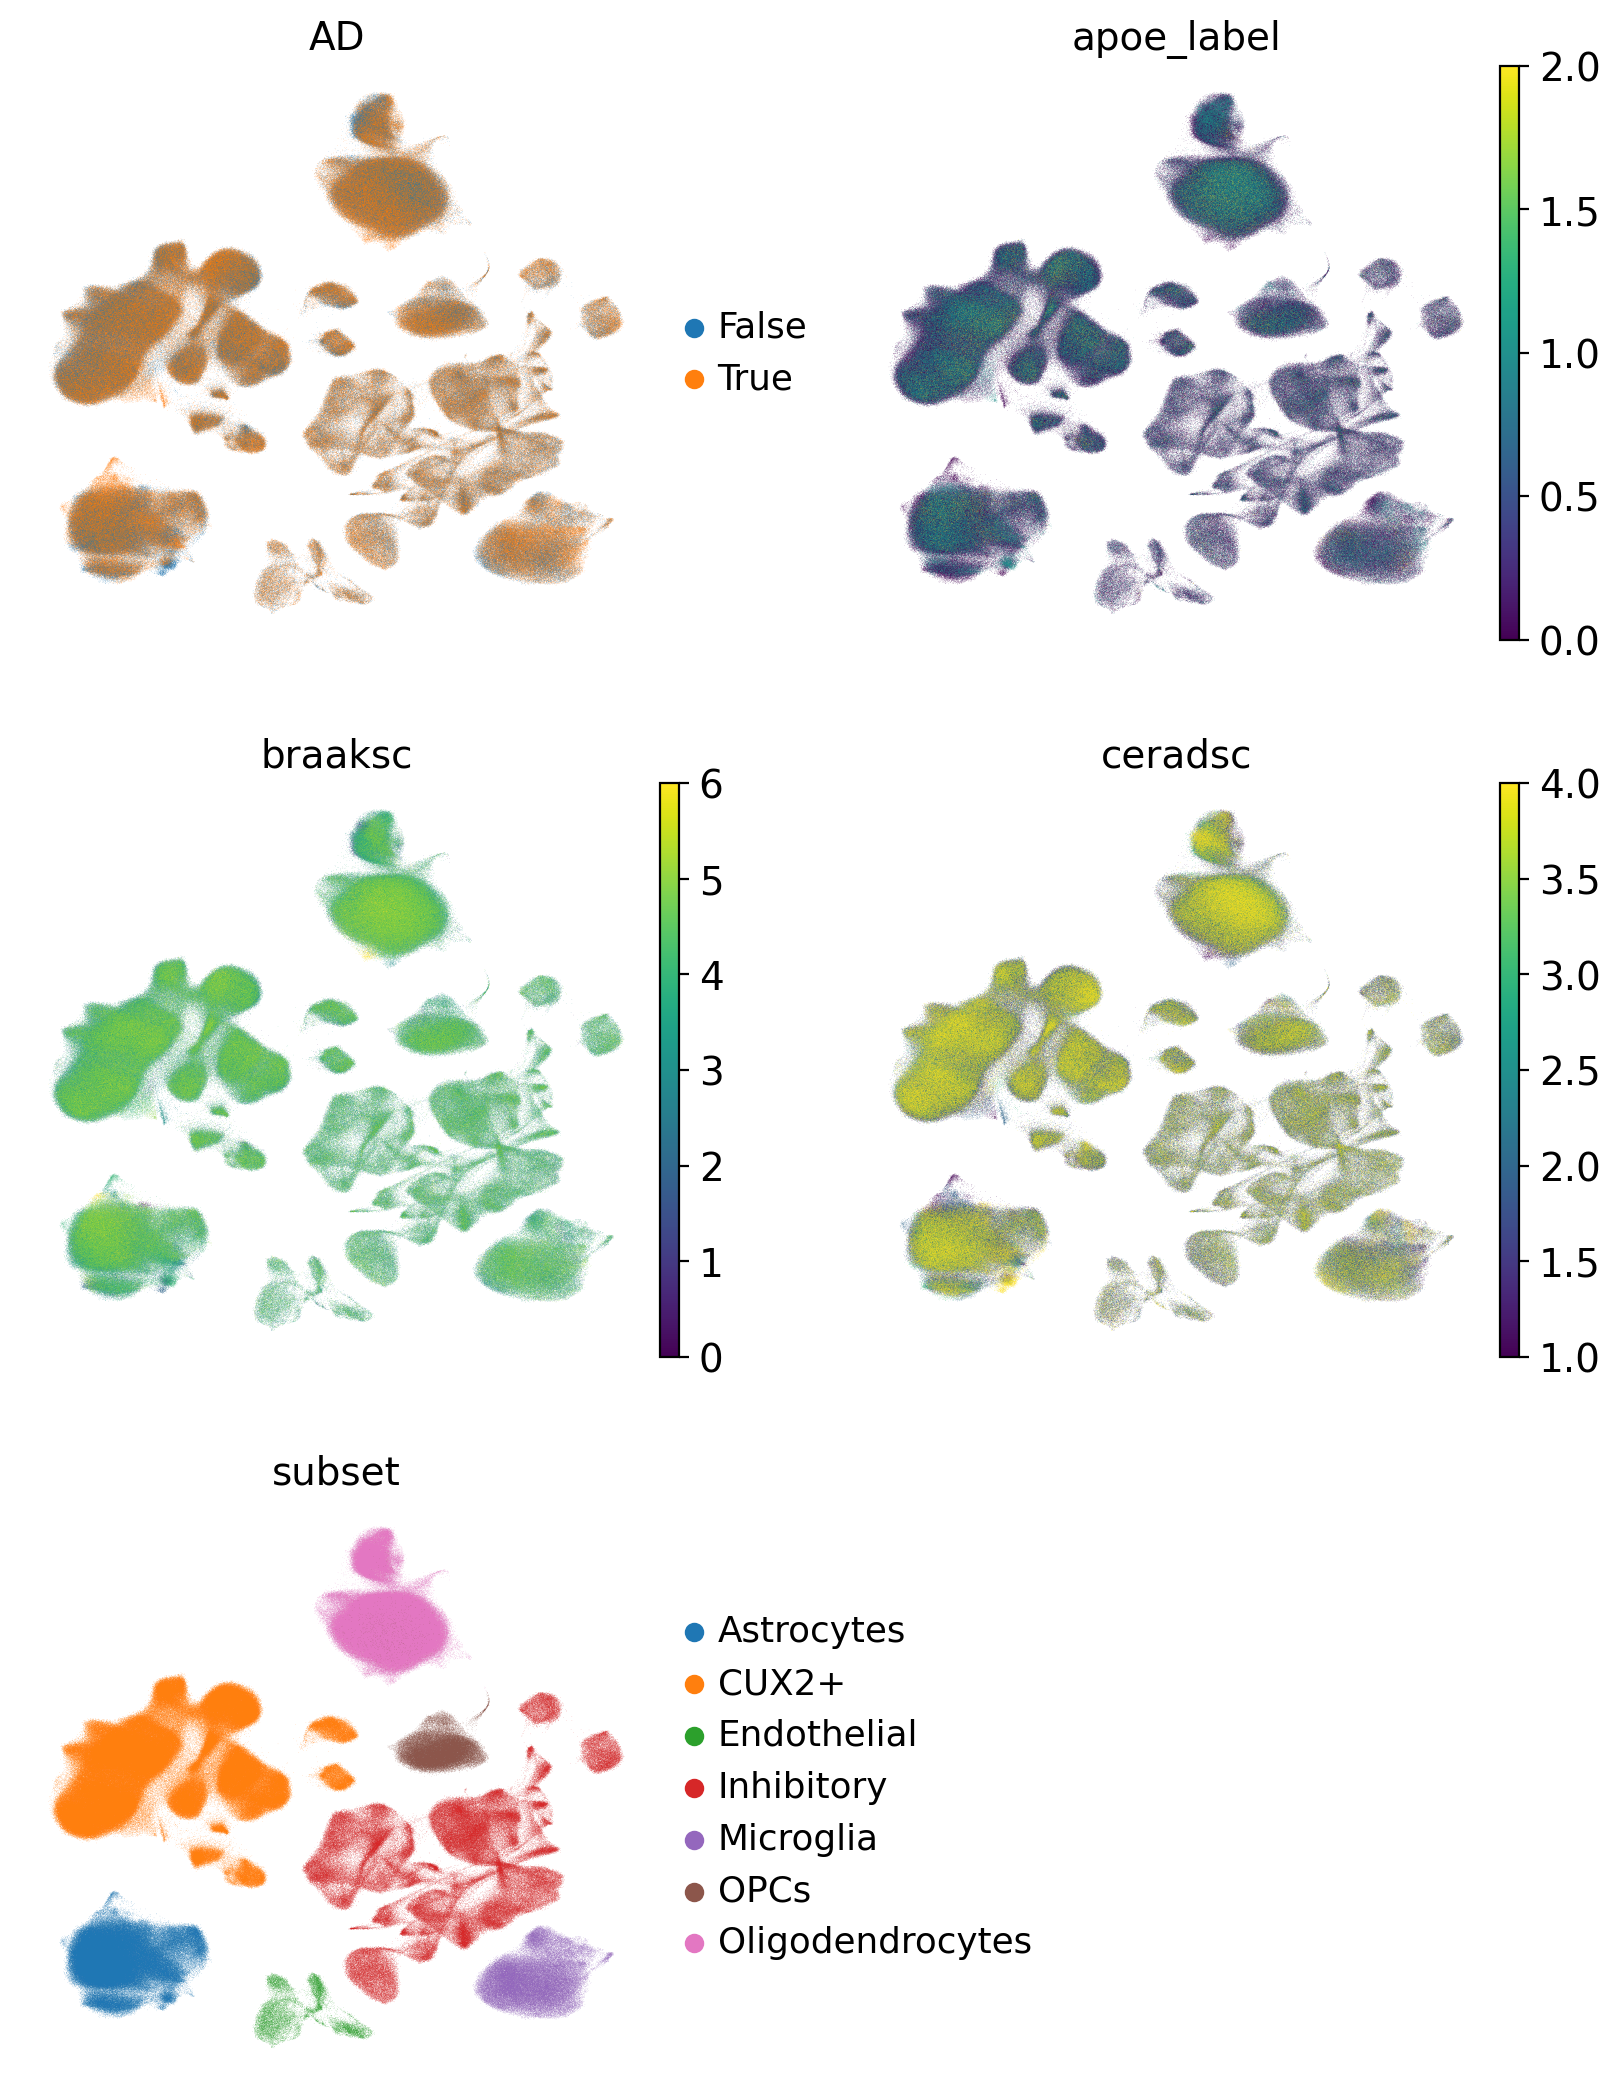

In [10]:
sc.pl.umap(adata, color = ['AD', 'apoe_label', 'braaksc', 'ceradsc', 'subset'], ncols = 2)

## predictions apoe

In [4]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready.h5ad')

In [5]:
sample_key = 'individualID'
classification_keys = ["apoe_label"]
z_dim = 30
categorical_covariate_keys = classification_keys + [sample_key]

In [6]:
new_adata = ad.AnnData(X=adata.obsm['X_scVI'])
new_adata.obs = adata.obs.copy()
new_adata.obsm = adata.obsm.copy()

In [ ]:
attn_df = pd.DataFrame()
for seed in [0]:

    scvi.settings.seed = seed

    samples = np.unique(adata.obs[sample_key])
    n_samples = len(samples)
    query_proportion = 0.2
    rng = np.random.default_rng(seed)
    query_samples = rng.choice(samples, int(n_samples * query_proportion), replace=False)
    
    # separate query and training adata
    query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
    adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()
    query.obs["ref"] = "query"
    adata.obs["ref"] = "reference"
    
    # sort index in both training adata and query 
    idx = adata.obs[sample_key].sort_values().index
    adata = adata[idx].copy()
    idx = query.obs[sample_key].sort_values().index
    query = query[idx].copy()
    
    # set up adata for traning
    mtm.model.MILClassifier.setup_anndata(
        adata,
        categorical_covariate_keys=categorical_covariate_keys,
    )
    # train mil model on training set
    print('seeeeeeeeeeeeeeeeeeeed', seed)
    
    mil = mtm.model.MILClassifier(
        adata,
        classification=classification_keys,
        z_dim=z_dim,
        sample_key=sample_key,
        # class_loss_coef = 0.1,
        # dropout = 0.05,
        # n_layers_cell_aggregator = 16,
        # n_layers_classifier = 4,
    )
    
    mil.train(lr=1e-4, max_epochs = 300, progress_bar_refresh_rate=0.5, train_size = 0.8, batch_size = 256, check_val_every_n_epoch=1)
    mil.plot_losses()
    mil.get_model_output()
    
    # set up query data and infernece on query data
    mtm.model.MILClassifier.setup_anndata(
        query,
        categorical_covariate_keys=categorical_covariate_keys,
    )
    new_model = mtm.model.MILClassifier.load_query_data(query, mil)
    new_model.get_model_output()
    
    # attach query to adata and show umap for the whole dataset
    adata_both = ad.concat([adata, query]) 
    sc.set_figure_params(figsize = (5,5))
    sc.pl.umap(adata_both, color=["apoe_label", "predicted_apoe_label", "cell_attn", 'subset'], ncols=2, frameon=False, vmax="p99")
    
    # calculate accuracy score on the query dataset
    accuracy = accuracy_score(query.obs["apoe_label"], query.obs["predicted_apoe_label"])
    print('accuracy', accuracy)
    
    col_name = 'cell_attn_'+str(seed)
    attn_df[col_name] = query.obs['cell_attn']    

[rank: 0] Global seed set to 0


seeeeeeeeeeeeeeeeeeeed 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 196/300:  65%|██████████████████████████████████████▎                    | 195/300 [1:45:03<52:24, 29.95s/it, loss=0.213, v_num=1]

In [ ]:
attn_df.to_csv('attn_df_apoe_multimil.csv')

In [ ]:
mil.plot_losses()

In [ ]:
mil.get_model_output()
    
# set up query data and infernece on query data
mtm.model.MILClassifier.setup_anndata(
    query,
    categorical_covariate_keys=categorical_covariate_keys,
)
new_model = mtm.model.MILClassifier.load_query_data(query, mil)
new_model.get_model_output()

# attach query to adata and show umap for the whole dataset
adata_both = ad.concat([adata, query]) 
sc.set_figure_params(figsize = (5,5))
sc.pl.umap(adata_both, color=["apoe_label", "predicted_apoe_label", "cell_attn", 'subset'], ncols=2, frameon=False, vmax="p99")

# calculate accuracy score on the query dataset
accuracy = accuracy_score(query.obs["apoe_label"], query.obs["predicted_apoe_label"])
print('accuracy', accuracy)



# col_name = 'cell_attn_'+str(seed)
# attn_df[col_name] = query.obs['cell_attn']

In [ ]:
# Randomly choose indices
random_indices = np.random.choice(adata_both.n_obs, size=10000, replace=False)

# Subset the AnnData object
adata_subset = adata_both[random_indices].copy()

In [ ]:
adata_subset.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready_attn_apoe_subset.h5ad')

In [13]:
adata_subset

AnnData object with n_obs × n_vars = 10000 × 30
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels', 'AD', 'apoe_label', 'ref', 'cell_attn', 'bags', 'predicted_apoe_label'
    uns: 'predicted_apoe_label_colors', 'subset_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'full_predictions_apoe_label'

## predictions disease

In [4]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready.h5ad')
# adata.obs = adata.obs.reset_index(drop = True)

In [5]:
sample_key = 'individualID'
classification_keys = ["AD"]
z_dim = 30
categorical_covariate_keys = classification_keys + [sample_key]

In [6]:
new_adata = ad.AnnData(X=adata.obsm['X_scVI'])
new_adata.obs = adata.obs.copy()
new_adata.obsm = adata.obsm.copy()

In [7]:
# take out 10% common test set for comparason 
seed = 42
test_proportion = 0.1
rng = np.random.default_rng(seed)
samples = np.unique(adata.obs[sample_key])
n_samples = len(samples)
test_samples = rng.choice(samples, int(n_samples * test_proportion), replace=False)
remaining_samples = np.setdiff1d(samples, test_samples)

test = new_adata[new_adata.obs[sample_key].isin(test_samples)].copy()
test.obs["ref"] = "test"

[rank: 0] Global seed set to 0
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


seeeeeeeeeeeeeeeeeeeed 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-70ec9ffd-2999-5651-9809-82ada0677edd]


Epoch 1000/1000: 100%|██████████████████████████████████████████████████████| 1000/1000 [6:37:36<00:00, 25.51s/it, loss=0.0555, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████████████████████████████████████████████████| 1000/1000 [6:37:37<00:00, 23.86s/it, loss=0.0555, v_num=1]


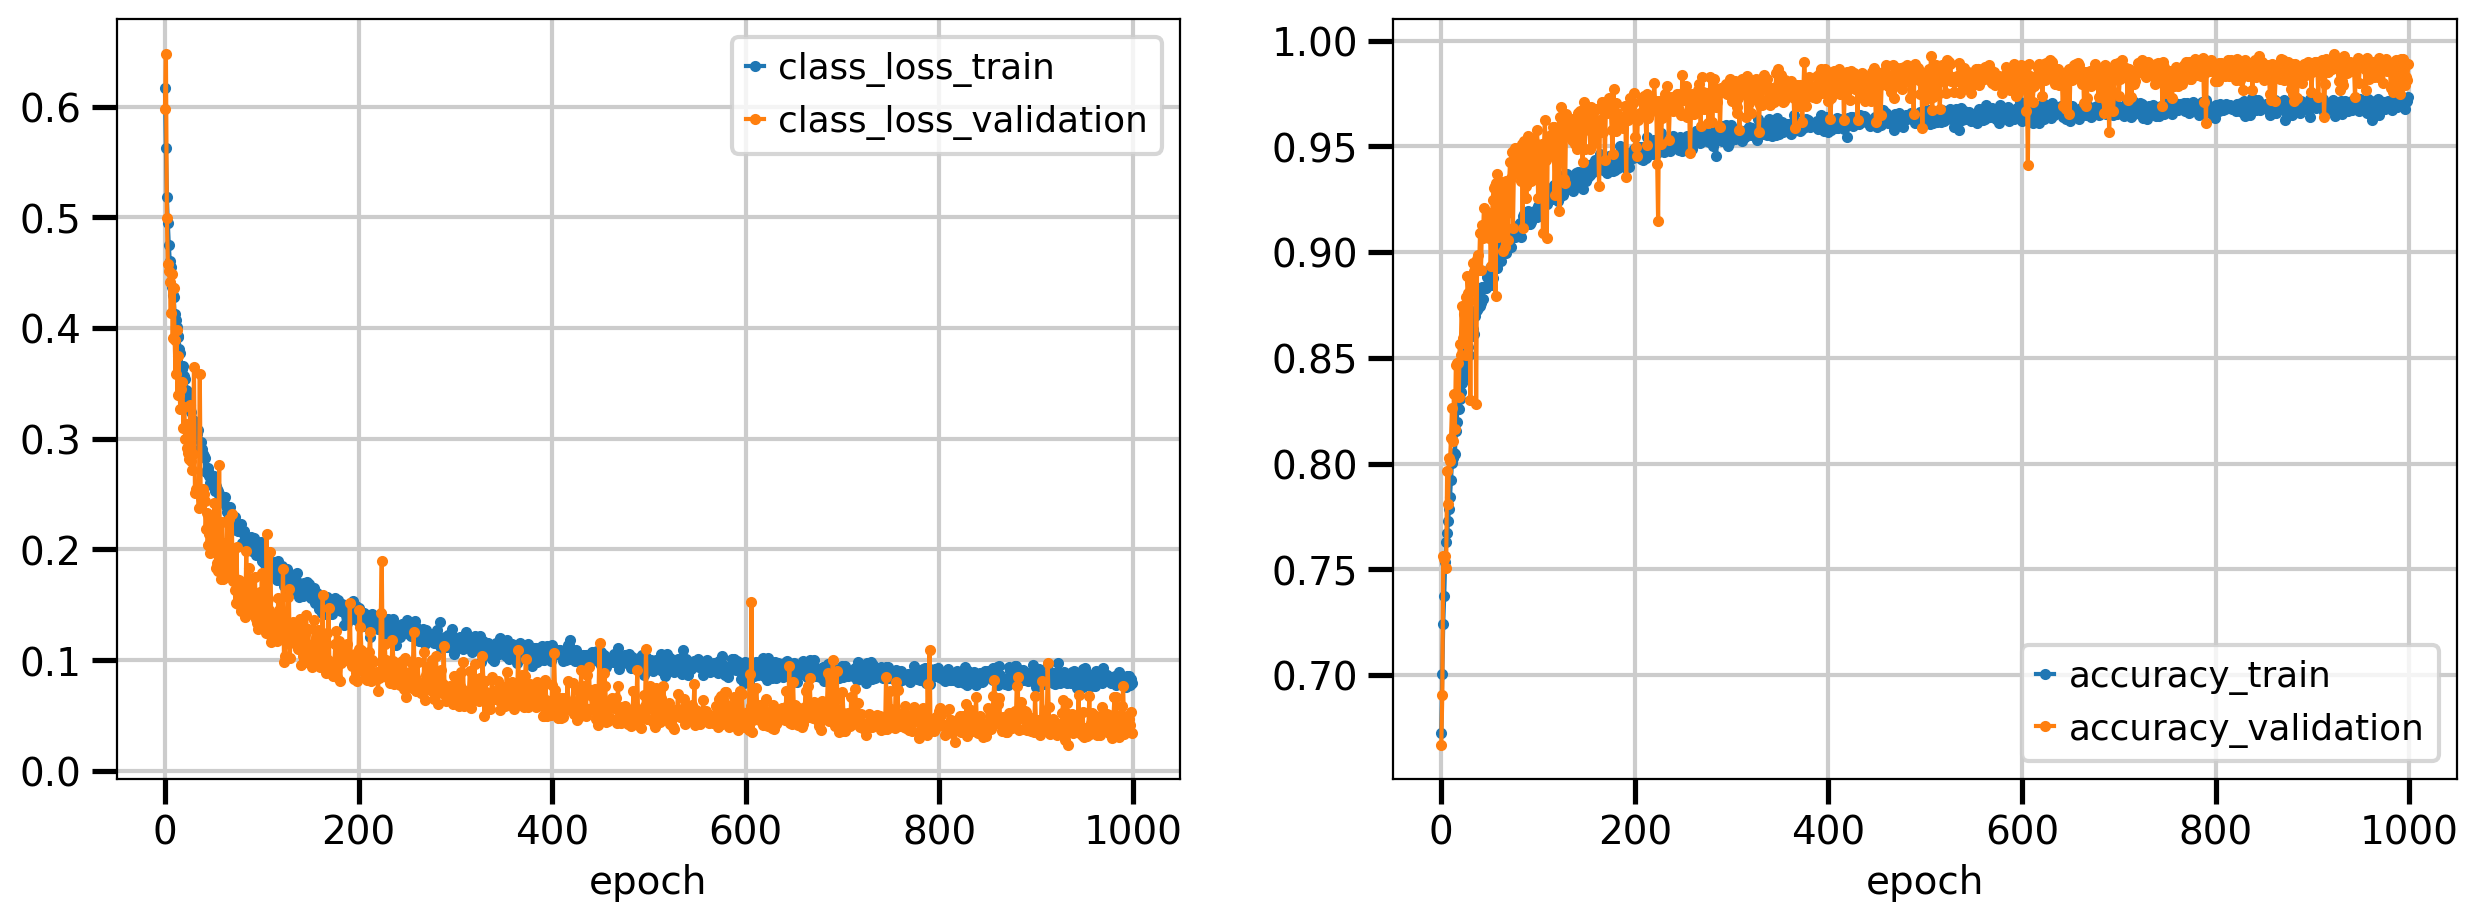

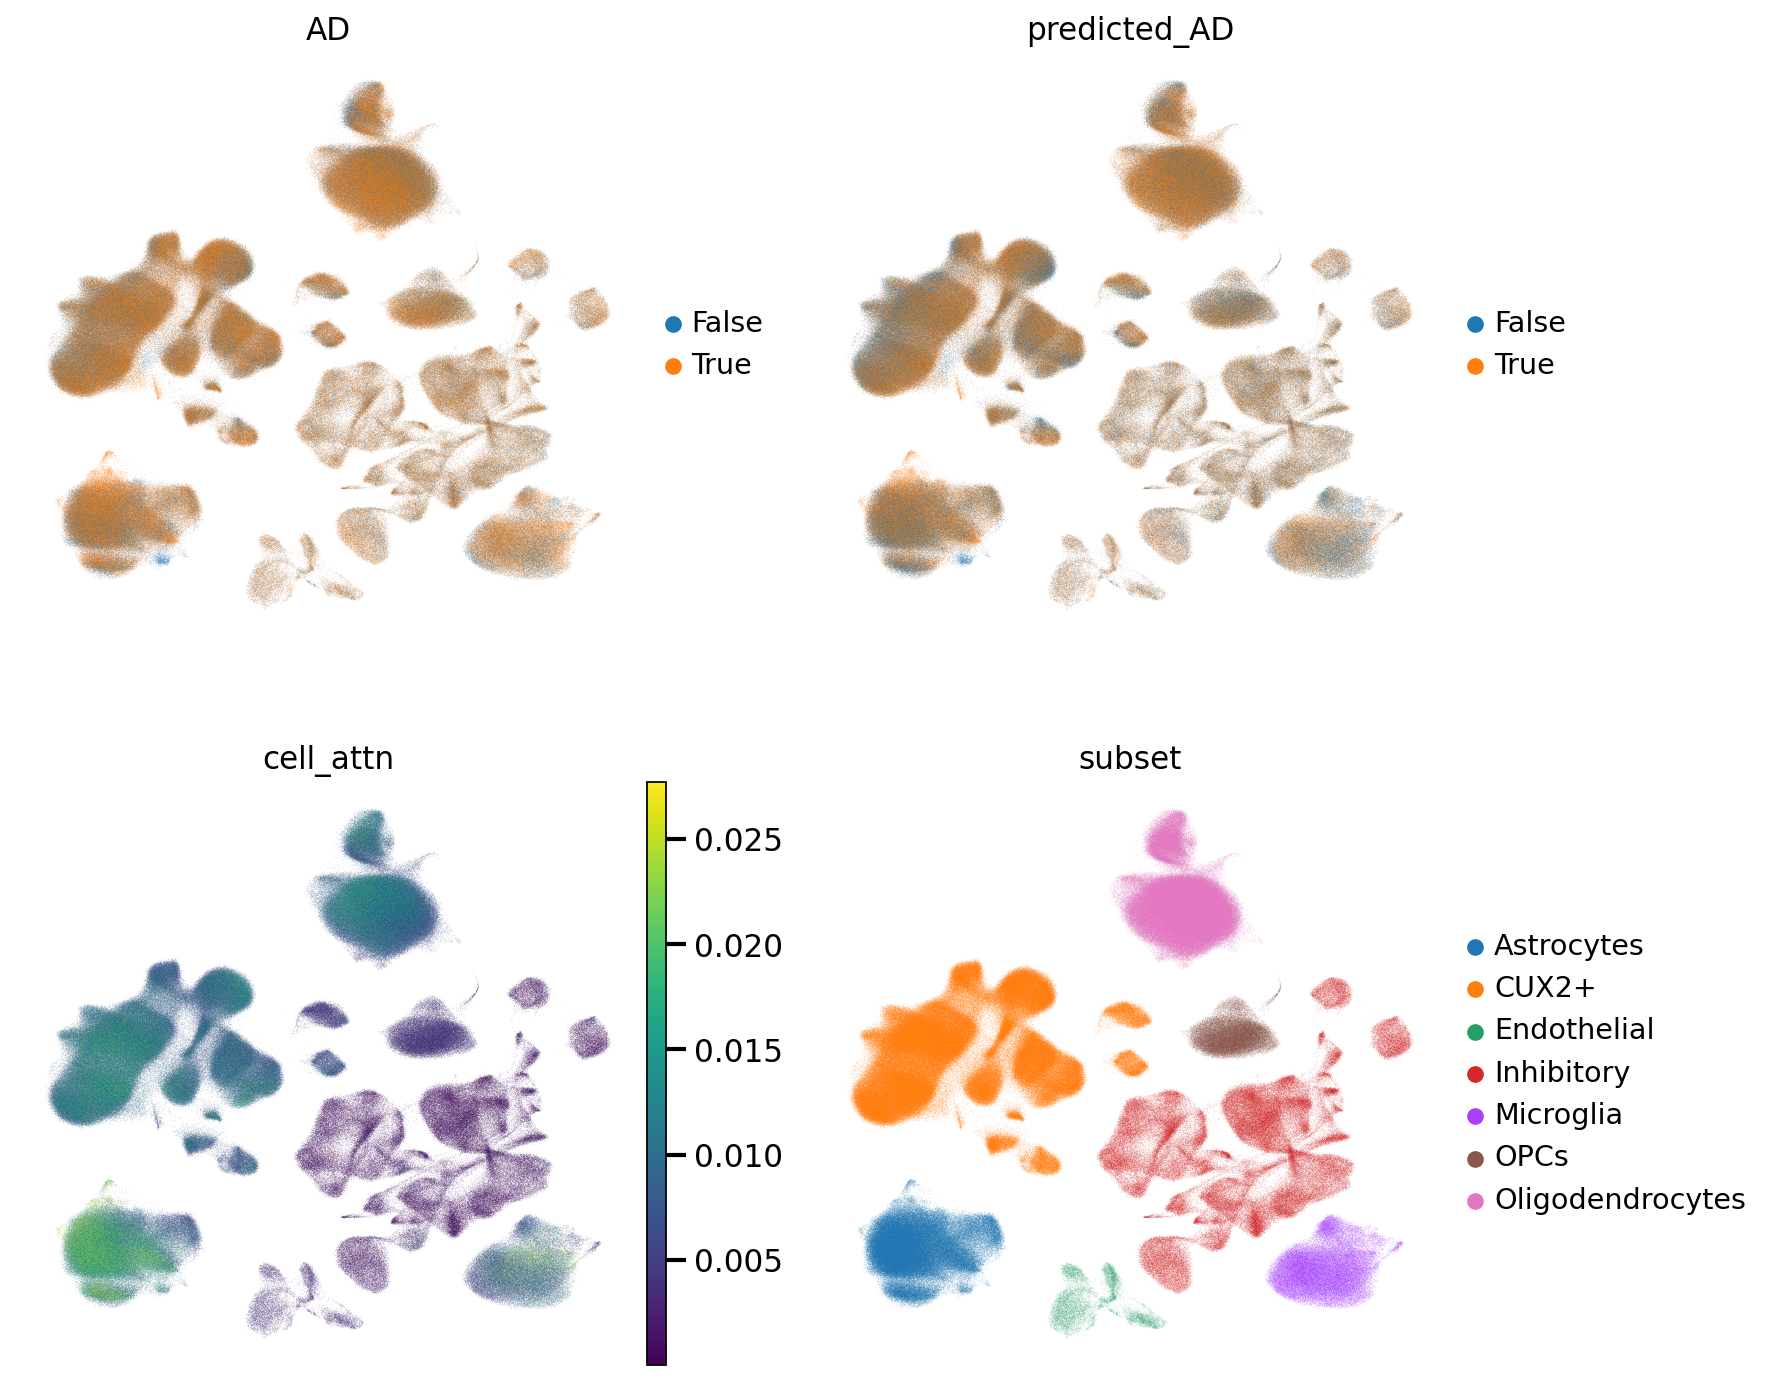

[rank: 0] Global seed set to 1


accuracy 0.5226040635459388
seeeeeeeeeeeeeeeeeeeed 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-70ec9ffd-2999-5651-9809-82ada0677edd]


Epoch 145/1000:  14%|█████▌                                 | 144/1000 [57:06<6:13:24, 26.17s/it, loss=0.0458, v_num=1]

In [ ]:
attn_df = pd.DataFrame()
for seed in [0, 1, 2, 3, 4]:
    scvi.settings.seed = seed
    
    query_proportion = 0.2
    
    rng = np.random.default_rng(seed)
    query_samples = rng.choice(remaining_samples, int(n_samples * query_proportion), replace=False)
    
    # separate query and training adata
    query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
    adata = new_adata[~new_adata.obs[sample_key].isin(query_samples) & 
                  ~new_adata.obs[sample_key].isin(test_samples)].copy()
    query.obs["ref"] = "query"
    adata.obs["ref"] = "reference"
    
    # sort index in both training adata and query 
    idx = adata.obs[sample_key].sort_values().index
    adata = adata[idx].copy()
    idx = query.obs[sample_key].sort_values().index
    query = query[idx].copy()
    
    # set up adata for traning
    mtm.model.MILClassifier.setup_anndata(
        adata,
        categorical_covariate_keys=categorical_covariate_keys,
    )
    # train mil model on training set
    print('seeeeeeeeeeeeeeeeeeeed', seed)
    
    mil = mtm.model.MILClassifier(
        adata,
        classification=classification_keys,
        z_dim=z_dim,
        sample_key=sample_key,
        # class_loss_coef = 0.1,
        # dropout = 0.05,
        # n_layers_cell_aggregator = 16,
        # n_layers_classifier = 4,
    )
    
    mil.train(lr=0.001, max_epochs = 1000, progress_bar_refresh_rate=0.5, train_size = 0.8, batch_size = 256, early_stopping = False, check_val_every_n_epoch=1)
    mil.plot_losses()
    mil.get_model_output()
    
    # set up query data and infernece on query data
    mtm.model.MILClassifier.setup_anndata(
        test,
        categorical_covariate_keys=categorical_covariate_keys,
    )
    new_model = mtm.model.MILClassifier.load_query_data(test, mil)
    new_model.get_model_output()
    
    # attach query to adata and show umap for the whole dataset
    adata_both = ad.concat([adata, test]) 
    sc.set_figure_params(figsize = (5,5))
    sc.pl.umap(adata_both, color=["AD", "predicted_AD", "cell_attn", 'subset'], ncols=2, frameon=False, vmax="p99")
    
    # calculate accuracy score on the query dataset
    accuracy = accuracy_score(test.obs["AD"], test.obs["predicted_AD"])
    print('accuracy', accuracy)
    
    col_name = 'cell_attn_'+str(seed)
    attn_df[col_name] = test.obs['cell_attn']    

In [ ]:
attn_df

In [ ]:
attn_df_annot = pd.concat([test.obs, attn_df], axis = 1) 

In [ ]:
attn_df_annot.groupby('subset', group_keys = False).count()[sample_key].rename_axis(None)

In [ ]:
## top 10% cells by attention score for each seed
top_type = pd.DataFrame()
for seed in [0, 1, 2, 3, 4]:
    col_name = 'cell_attn_' + str(seed)
    col_series = attn_df_annot.sort_values(by = [col_name], ascending=False)[:1541].groupby('subset', group_keys = False).count()[sample_key].rename_axis(None)
    col_name = 'seed_' + str(seed)
    top_type[col_name] = col_series

In [ ]:
top_type